# Muon
$G_t = \nabla_\theta f(\theta_{t-1})$

$B_t = \mu B_{t-1} + G_t$

$O_t = \text{NewtonSchulz}(B_t)$

$\theta_t = \theta_{t-1} - \eta O_t$

Muon: https://kellerjordan.github.io/posts/muon/

### Orthogonalizing the momentum update
By SVD, we have $G = USV^T$ where $U$ and $V^T$ are orthogonal and $S$ is diagonal.

We want to find $O = UV^T$ without having to compute the SVD (slow). Enter Newton-Schulz.

### Newton-Schulz
$aG + b(GG^T)G + c(GG^T)^2G$

$ = (a + bGG^T + c(GG^T)^2)G$

$ = (a + b US^2U^T + c US^4U^T)G$

$ = (aUSV^T + b US^3V^T + c US^5V^T)$

$ = U (aS + bS^3 + cS^5) V^T$

Computing $aG + b(GG^T)G + c(GG^T)^2G = U (aS + bS^3 + cS^5) V^T$, we apply a quintic polynomial directly to the singular values of G just by matrix multiplication (no SVD).

Let $\phi(x) = ax + bx^3 + cx^5$

Then $aG + b(GG^T)G + c(GG^T)^2G = U (aS + bS^3 + cS^5) V^T = U \phi(S) V^T$

N steps of Newton-Schulz gives $U \phi^N(S) V^T$

We want to find $O = UV^T$, ie make $S = 1$.

So we want to find a polynomial $\phi(x)$ st $\phi^N(x)$ maps $[0, 1] \to 1$.

Then, if we start with a matrix with $S \in [0, 1]$, we just apply Newton-Schulz N-times and get $O$.

To get $S \in [0, 1]$, we normalize $G / ||G||_F$, where $||G||_F$ is the Frobenius norm.

$||G||_F = \sqrt{\sum a_{ij}^2} = \sqrt{\text{tr}(GG^T)}$

$ = \sqrt{\text{tr}(US^2U^T)}$

$ = \sqrt{\text{tr}(S^2)} \qquad$ b/c $ \ \text{tr}(XYZ) = \text{tr}(YXZ)$

$ = \sqrt{\sum \sigma^2}$

Now we have to choose parameters for $\phi(x) = ax + bx^3 + cx^5$

### Tuning Newton-Schulz coeffs

$\phi'(x) = a + 3bx^2 + 5cx^4$

$\phi'(0) = a$

So to get singular values close to 0 to converge to 1 as quickly as possible, we want to make a very large.

Empirically, Muon authors found that singular values do not actually have to converge to 1, just $[1-\epsilon, 1+\epsilon]$ with $\epsilon = 0.3$.

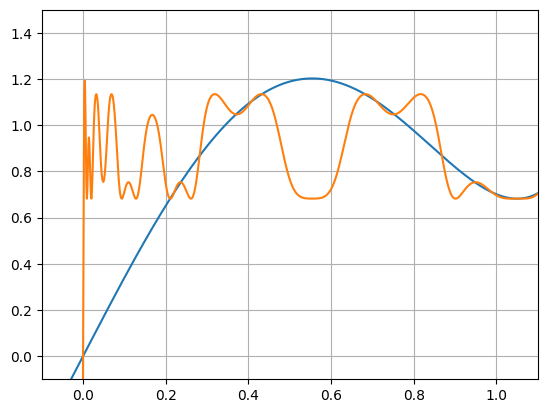

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def phi(a, b, c, x):
    return a*x + b*(x**3) + c*(x**5)

a, b, c = 3.4445, -4.7750, 2.0315
x = np.linspace(-0.1, 1.1, num=1000)
y = phi(a, b, c, x)
z = y
for i in range(4):
    z = phi(a, b, c, z)

plt.plot(x, y)
plt.plot(x, z)
plt.grid()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.5)
plt.show()

### Optimizer

In [2]:
import torch

class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    @torch.no_grad()
    def zero_grad(self):
        for p in self.parameters:
            p.grad = None

In [3]:
class Muon(Optimizer):
    def __init__(self, parameters, lr: float = 1e-3, weight_decay: float = 0, momentum: float = 0.99, eps: float = 1e-9):
        super().__init__(parameters)
        self.lr = lr
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.momentum_buffers = [torch.zeros_like(p, requires_grad=False) for p in self.parameters]
        self.eps = eps

    @torch.no_grad()
    def step(self):
        for i, p in enumerate(self.parameters):
            g = p.grad.detach().clone()
            self.momentum_buffers[i] = self.momentum*self.momentum_buffers[i] + (1-self.momentum)*g
            O = self.newton_schulz(self.momentum_buffers[i] / (self.momentum_buffers[i].norm() + self.eps))
            if self.weight_decay:
                p -= self.lr * self.weight_decay * p
            p -= self.lr * O

    @torch.no_grad()
    def newton_schulz(self, G: torch.Tensor) -> torch.Tensor:
        a, b, c = 3.4445, -4.7750, 2.0315
        X = G
        if G.shape[-1] < G.shape[-2]:
            X = G.T
        for _ in range(5):
            X2 = X @ X.T
            X4 = X2 @ X2
            X = (a * X) + (b*X2 + c*X4) @ X
        if G.shape[-1] < G.shape[-2]:
            X = X.T
        return X

0: loss=0.104204, acc=0.960938
1: loss=0.109751, acc=0.953125


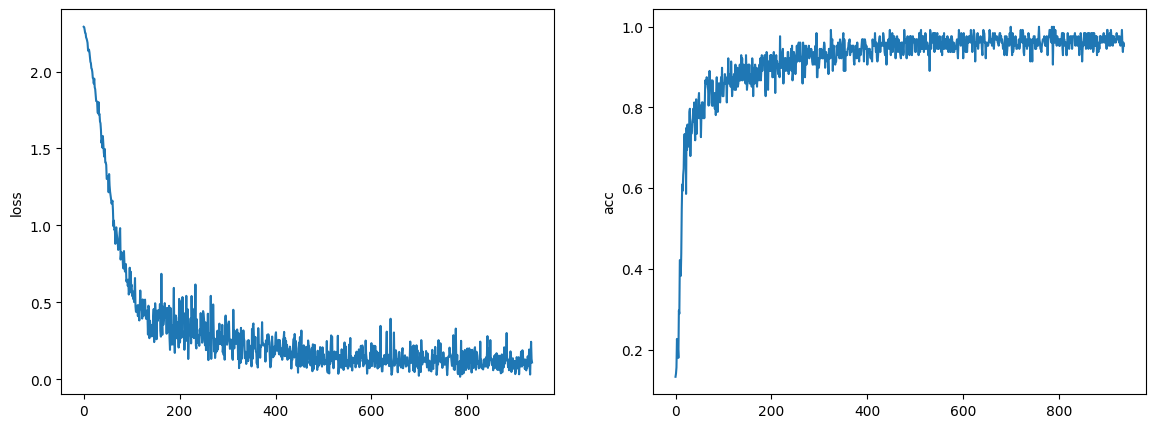

In [4]:
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torchvision.datasets import MNIST
from torchvision.transforms import v2
import matplotlib.pyplot as plt

@torch.no_grad()
def calc_acc(logits: torch.Tensor, target: torch.Tensor) -> float:
    return (logits.argmax(dim=-1) == target).to(dtype=torch.float32).mean().item()

transform = v2.Compose([v2.ToImage(), v2.ToDtype(dtype=torch.float32, scale=True)])
train_ds = MNIST("data", train=True, transform=transform, download=True)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

model = nn.Sequential(nn.Flatten(), nn.Linear(784, 64), nn.ReLU(), nn.Linear(64, 10)).to("cuda")

muon_params, adamw_params = [], []
for p in model.parameters():
    if p.dim() == 2:
        muon_params.append(p)
    else:
        adamw_params.append(p)
muon = Muon(muon_params, lr=1e-2, weight_decay=1e-2, momentum=0.99)
adamw = AdamW(adamw_params, lr=1e-2, weight_decay=1e-2, betas=(0.9, 0.999))

losses, accs = [], []
for epoch in range(2):
    for x, y in train_dl:
        x, y = x.to("cuda"), y.to("cuda")
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        muon.zero_grad()
        adamw.zero_grad()
        loss.backward()
        muon.step()
        adamw.step()

        losses.append(loss.item())
        accs.append(calc_acc(logits, y))
    print(f"{epoch}: loss={losses[-1]:.6f}, acc={accs[-1]:.6f}")

_, (loss_ax, acc_ax) = plt.subplots(ncols=2, figsize=(14, 5))
loss_ax.plot(losses)
loss_ax.set_ylabel("loss")
acc_ax.plot(accs)
acc_ax.set_ylabel("acc")
plt.show()

### TODO:
* https://jeremybernste.in/writing/deriving-muon
* Modula Newton-Schulz: https://docs.modula.systems/algorithms/newton-schulz/#
* Polar Express: https://arxiv.org/pdf/2505.16932